<a href="https://colab.research.google.com/github/Only-Mike/ADHD/blob/main/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import data and concat data

In [1]:
import pandas as pd
import numpy as np

In [2]:
!git clone 'https://github.com/Only-Mike/ADHD.git'

fatal: destination path 'ADHD' already exists and is not an empty directory.


In [3]:
data1 = pd.read_csv('/content/ADHD/datasets/adhd2018.csv')
data2 = pd.read_csv('/content/ADHD/datasets/adhd2019.csv')
data3 = pd.read_csv('/content/ADHD/datasets/adhd2020.csv')
data4 = pd.read_csv('/content/ADHD/datasets/adhd2021.csv')
data5 = pd.read_csv('/content/ADHD/datasets/adhd2022.csv')
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets
df = pd.concat(frames) #Concat all datasets to "df"

#Prep for data handling/Topic Modelling

In [4]:
#Installing preprocessor to celan our text
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

# explainability (why did the model say it's related to this author)
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import tqdm #progress bar
import preprocessor as prepro # text prepro

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [6]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

# Topic modelling

In [7]:
df.head()

,Authors,Author(s) ID,Title,Year,Cited by,Link,Affiliations,Authors with affiliations,Abstract,Author Keywords,EID
0,"Danielson M.L., Bitsko R.H., Ghandour R.M., Ho...",57212872865;22133380600;6507545467;55931285700...,Prevalence of Parent-Reported ADHD Diagnosis a...,2018,470.0,https://www.scopus.com/inward/record.uri?eid=2...,National Center on Birth Defects and Developme...,"Danielson, M.L., National Center on Birth Defe...",The purpose of this study is to estimate the n...,NaN,2-s2.0-85043366583
1,"Savage J.E., Jansen P.R., Stringer S., Watanab...",56108103800;57194519231;54407564900;5720462432...,"Genome-wide association meta-analysis in 269,8...",2018,431.0,https://www.scopus.com/inward/record.uri?eid=2...,"Department of Complex Trait Genetics, Center f...","Savage, J.E., Department of Complex Trait Gene...",Intelligence is highly heritable 1 and a major...,NaN,2-s2.0-85048943479
2,"Cortese S., Adamo N., Del Giovane C., Mohr-Jen...",8651678100;36151905300;35572846200;55968380300...,Comparative efficacy and tolerability of medic...,2018,403.0,https://www.scopus.com/inward/record.uri?eid=2...,"Center for Innovation in Mental Health, Academ...","Cortese, S., Center for Innovation in Mental H...",Background: The benefits and safety of medicat...,NaN,2-s2.0-85051242636
3,"Sayal K., Prasad V., Daley D., Ford T., Coghil...",6701748666;7203041562;7006105495;7202760757;66...,"ADHD in children and young people: prevalence,...",2018,327.0,https://www.scopus.com/inward/record.uri?eid=2...,"Division of Psychiatry and Applied Psychology,...","Sayal, K., Division of Psychiatry and Applied ...",Attention-deficit hyperactivity disorder (ADHD...,NaN,2-s2.0-85030750499
4,"Franke B., Michelini G., Asherson P., Banasche...",57211894018;55959024400;35402700900;6603935963...,"Live fast, die young? A review on the developm...",2018,229.0,https://www.scopus.com/inward/record.uri?eid=2...,"Department of Human Genetics, Donders Institut...","Franke, B., Department of Human Genetics, Dond...",Attention-deficit/hyperactivity disorder (ADHD...,Adult-onset ADHD; Cognitive impairment; Comorb...,2-s2.0-85052888875


In [8]:
data = df[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Cited by']]

In [9]:
#Take a random sample of 2000 papers. This is for making the model run faster.
data = data.sample(n=2000)

In [10]:
#Making a new column called "text" from the abstract column
data['text'] = data['Abstract']

In [11]:
#Cleaning the text
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))


In [12]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|█████████▉| 1998/2000 [00:50<00:00, 170.09it/s]

In [13]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [14]:
data['text_clean'] = text_prepro(data['text'])

100%|██████████| 2000/2000 [00:29<00:00, 67.12it/s] 


In [15]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [16]:
data['tokens'] = tokens

In [17]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=2, no_above=0.2, keep_n=1000)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

##Visualization

In [18]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=12, workers = 4, passes=10)

In [19]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [20]:
pyLDAvis.display(lda_display)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [22]:
corpus = data['tokens']

In [23]:
corpus

1661    [background, population, child, adolescent, cu...
1749    [present, study, role, psychostimulant, dexamp...
284     [background, efficacy, intervention, poor, men...
934     [objective, determine, association, repetitive...
59      [objective, phase, trial, efficacy, safety, pe...
                              ...                        
1977    [agent, largely, responsible, dental, carie, s...
1141    [background, child, frequently, high, rate, be...
1563    [psychopathy, adhd, highly, comorbid, disorder...
409     [objective, objective, study, evaluate, rate, ...
1526    [importance, maternal, exposure, pregnancy, fa...
Name: tokens, Length: 2000, dtype: object

In [24]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [25]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [26]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [27]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [28]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

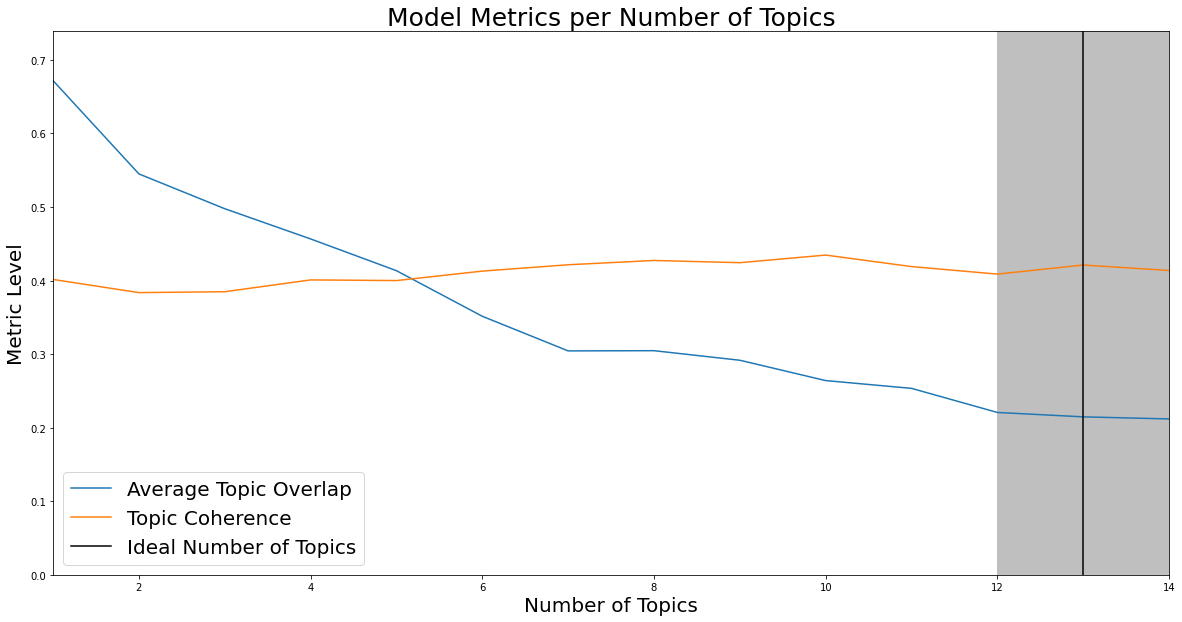

In [29]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  